1. Our Bayes factor assumed that we were looking at H1: P(prize) = 0.5. This allowed us to derive a version of the beta distribution with an alpha of 1 and a beta of 1. Would it matter if we chose a different probability for H1? Assume H1: P(prize) = 0.24, then see if the resulting distribution, once normalized to sum to 1, is any different than the original hypothesis.

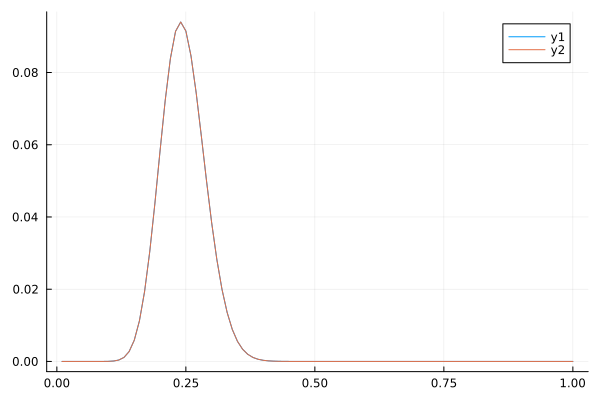

In [3]:
using Distributions, Plots
hypo = 0.01:0.01:1
function bfs(h, h1)
    low = h1^24*(1-h1)^76
    up = h.^24 .* (1 .- h).^76
    up ./ low
end
bfs1 = bfs(hypo, 0.5)
bfs2 = bfs(hypo, 0.24)

n_bfs1 = bfs1 ./ sum(bfs1)
n_bfs2 = bfs2 ./ sum(bfs2)

p = plot(hypo, [n_bfs1,n_bfs1])


2. Write a prior for the distribution in which each hypothesis is 1.05 times more likely than the previous hypothesis (assume our dx remains the same).

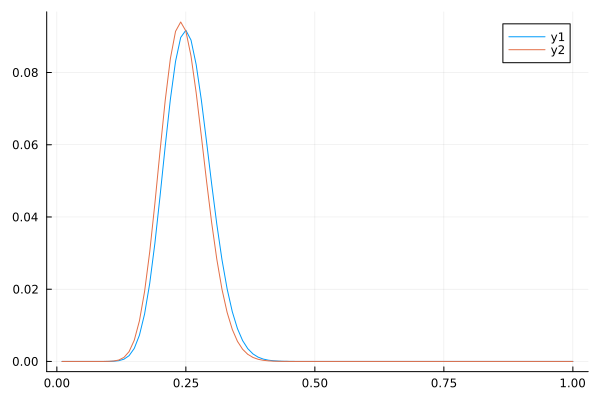

In [4]:
function prior(bfs)
    p = 1.0
    ps = [1.0,]
    for i in 1:(length(bfs) - 1)
        p *= 1.05
        push!(ps,p)
    end
    return ps
end

posteriors = bfs1 .* prior(bfs1)
n_posteriors = posteriors ./ sum(posteriors)

plot(hypo, [n_posteriors, n_bfs1])

3. Suppose you observed another duck game that included 34 ducks with prizes and 66 ducks without prizes. How would you set up a test to answer “What is the probability that you have a better chance of winning a prize in this game than in the game we used in our example?” Implementing this requires a bit more sophistication than the R used in this book, but see if you can learn this on your own to kick off your adventures in more advanced Bayesian statistics!

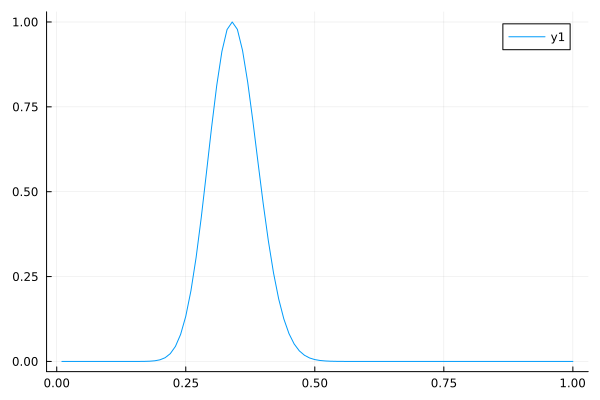

In [5]:
using Distributions, Plots

# Let's assume that the probability of winning in this game is 34/100
hps = 0.01:0.01:1
function bfs(h, h1)
    low = h1^34*(1-h1)^66
    up = h.^34 .* (1 .- h).^66
    up ./ low
end
bfsn = bfs(hps,0.34)
plot(hps,bfsn)

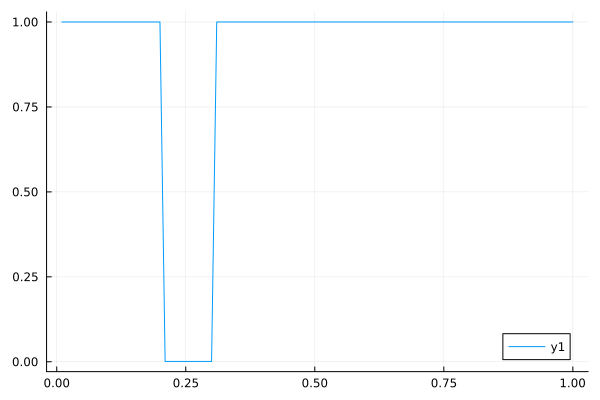

In [6]:
priors = [0.2 < x <= 0.3 ? 1/1000 : 1 for x in hps]
plot(hps,priors)

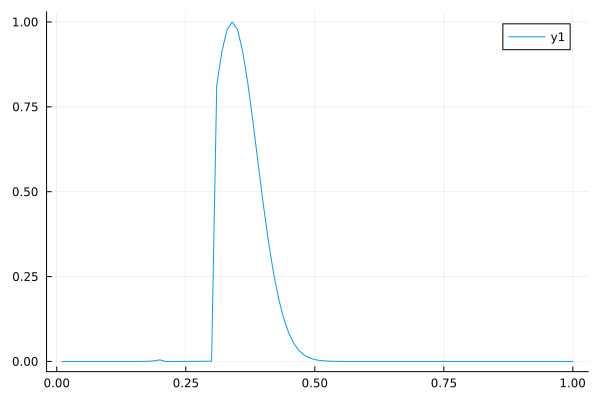

In [7]:
post = priors .* bfsn
plot(hps,post)

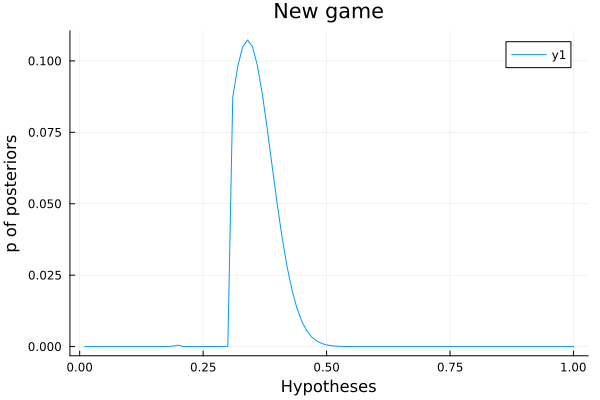

In [8]:
p_post = post ./ sum(post)
plot(hps,p_post, xlabel = "Hypotheses", ylabel = "p of posteriors", title = "New game")

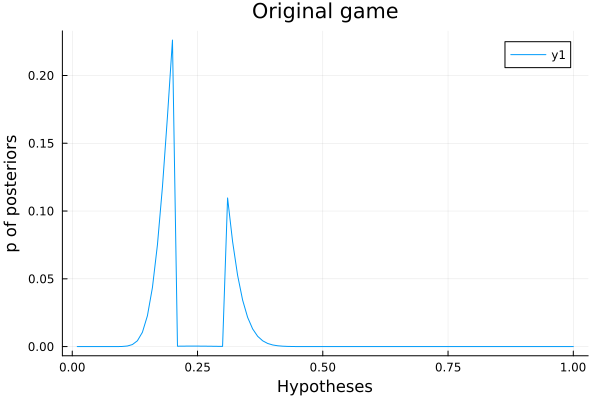

In [9]:
# We also need to make the posterior probability of the original game.
function bfo(h, h1)
    low = h1^24*(1-h1)^76
    up = h.^24 .* (1 .- h).^76
    up ./ low
end
bfos = bfo(hps,0.24)
posto = priors .* bfos
p_posto = posto ./ sum(posto)
plot(hps,p_posto, xlabel = "Hypotheses", ylabel = "p of posteriors", title = "Original game")

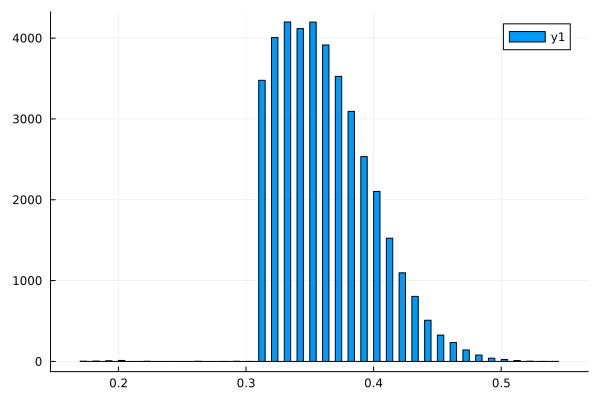

In [10]:
# Let's reject sampling for each of the two games
n = 1000000
target_n = 40000
x_loc = rand(1:length(hps), n)
u = Uniform(0, 1) 
# For new game:
uc = 0.11 .* pdf.(u, hps[x_loc]) # the max of p_post = 0.10729562911199936
s = []
c = length(s)
i = 1
while c < target_n
    if p_post[x_loc[i]] / uc[i] >= rand(u)
        push!(s, hps[x_loc[i]])
    end
    i += 1
    c = length(s)
end
histogram(s)

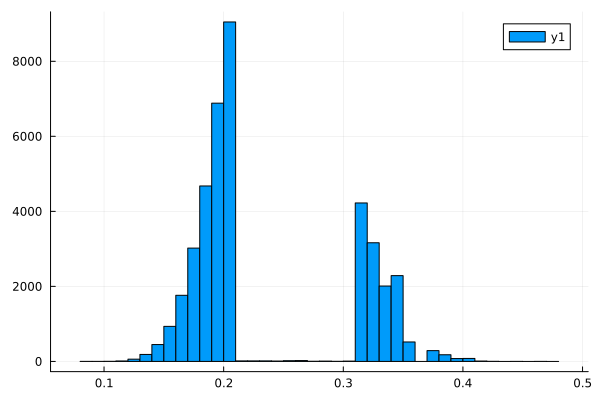

In [11]:
# For original game:
uco = 0.23 .* pdf.(u, hps[x_loc]) # the max of p_posto =  0.2261180961255154
so = []
co = length(so)
io = 1
while co < target_n
    if p_posto[x_loc[io]] / uco[io] >= rand(u)
        push!(so, hps[x_loc[io]])
    end
    io += 1
    co = length(so)
end
histogram(so)

In [12]:
sum(s .> so) / target_n

0.9157

So the answer is 0.92. Let's try **Metropolis**!

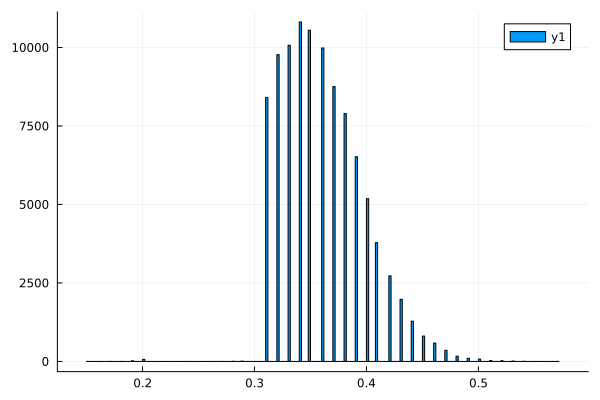

In [39]:
# For new game:
xₜ = 0.3
smps = []
f = Dict(hps .=> p_post)
while length(smps) < 100000
    xᵗ = round(rand(Normal(xₜ, 0.1)); digits=2)
    while xᵗ < 0.01 || xᵗ > 1
        xᵗ = round(rand(Normal(xₜ, 0.1)); digits=2)
    end
    fₜ = f[xₜ]
    fᵗ = f[xᵗ]
    α = fᵗ / fₜ
    u = rand(Uniform(0, 1))
    if α > u
        push!(smps, xᵗ)
        xₜ = xᵗ
    else
        push!(smps, xₜ)
        xₜ = xₜ
    end
end
histogram(smps)

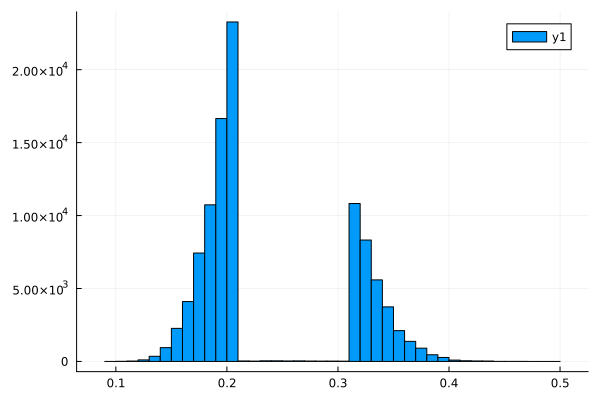

In [38]:
# For original game:
xₜ = 0.2
smpso = []
f = Dict(hps .=> p_posto)
while length(smpso) < 100000
    xᵗ = round(rand(Normal(xₜ, 0.1)); digits=2)
    while xᵗ < 0.01 || xᵗ > 1
        xᵗ = round(rand(Normal(xₜ, 0.1)); digits=2)
    end
    fₜ = f[xₜ]
    fᵗ = f[xᵗ]
    α = fᵗ / fₜ
    u = rand(Uniform(0, 1))
    if α > u
        push!(smpso, xᵗ)
        xₜ = xᵗ
    else
        push!(smpso, xₜ)
        xₜ = xₜ
    end
end
histogram(smpso)

In [45]:
sum(smps .> smpso) / 100000

0.91132